In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.io import loadmat
from scipy.signal import ellip, lfilter, filtfilt, find_peaks, butter, sosfiltfilt,sosfilt

In [ ]:
# Uncomment if you need google drive 
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#open leaderboard data
# leaderboard_data = loadmat('/content/drive/MyDrive/BE521 - BCI/PROJ_BE521/leaderboard_data.mat')
# raw_training_data = loadmat('/content/drive/MyDrive/BE521 - BCI/PROJ_BE521/raw_training_data.mat')
leaderboard_data = loadmat('..\\leaderboard_data.mat')
raw_training_data = loadmat('..\\raw_training_data.mat')

In [3]:
#glove data for training - per subject
train_dg_s1 = raw_training_data['train_dg'][0][0]
train_dg_s2 = raw_training_data['train_dg'][1][0]
train_dg_s3 = raw_training_data['train_dg'][2][0]

#ecog data for training - per subject
train_ecog_s1 = raw_training_data['train_ecog'][0][0]
train_ecog_s2 = raw_training_data['train_ecog'][1][0]
train_ecog_s3 = raw_training_data['train_ecog'][2][0]

#leaderboard ecog signal per patient
leaderboard_data_s1 = leaderboard_data['leaderboard_ecog'][0][0]
leaderboard_data_s2 = leaderboard_data['leaderboard_ecog'][1][0]
leaderboard_data_s3 = leaderboard_data['leaderboard_ecog'][2][0]

In [4]:
np.shape(train_ecog_s1)
#rows = ecog signal
#columns = channels

(300000, 62)

In [5]:
def filter_data(raw_eeg, fs=1000):
  """
  Write a filter function to clean underlying data.
  Filter type and parameters are up to you. Points will be awarded for reasonable filter type, parameters and application.
  Please note there are many acceptable answers, but make sure you aren't throwing out crucial data or adversly
  distorting the underlying data!

  Input: 
    raw_eeg (samples x channels): the raw signal
    fs: the sampling rate (1000 for this dataset)
  Output: 
    clean_data (samples x channels): the filtered signal
  """
  raw_eeg_t = raw_eeg.transpose()
  filtered = []

  nyq = fs/2

  #(b, a) = ellip(4, 0.1, 40, 20/nyq, btype='lowpass')
  sos = butter(8, [0.15,200],btype='bandpass',output='sos',fs=fs)

  for ch_data in raw_eeg_t:
    #filtered_ch = filtfilt(b, a, ch_data)
    filtered_ch = sosfiltfilt(sos,ch_data)
    filtered.append(filtered_ch)
  
  filtered = np.array(filtered)

  return filtered.transpose()

In [6]:
filt_train_ecog_s1 = filter_data(train_ecog_s1)

Text(0.5, 1.0, 'Subject 2 ECoG data with n=8 Butter Filter')

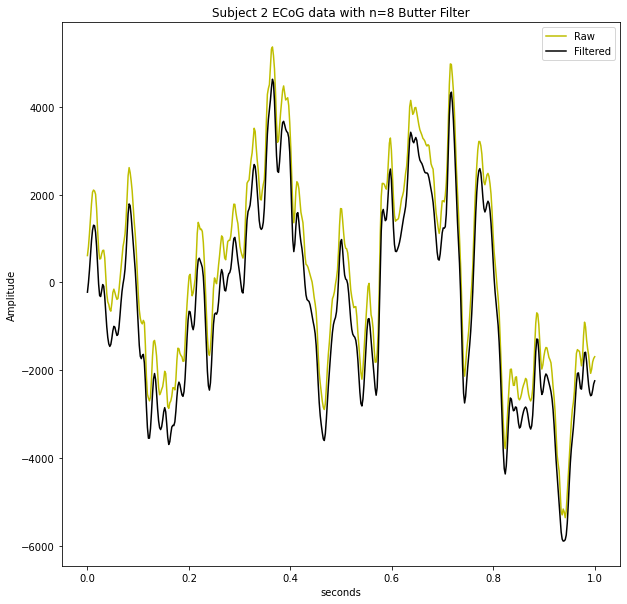

In [7]:
plt.figure(figsize=[10,10])
time = np.linspace(0,1,500)
plt.plot(time,train_ecog_s1.transpose()[0][0:500],'y')
plt.plot(time,filt_train_ecog_s1.transpose()[0][0:500],'k')
plt.legend(["Raw", "Filtered"])
plt.ylabel("Amplitude")
plt.xlabel("seconds")
plt.title("Subject 2 ECoG data with n=8 Butter Filter")

In [8]:
x_fft = np.fft.fft(filt_train_ecog_s1.transpose())
fs=1000 #sam/sec
freq_ax = fs/2 * np.linspace(0,1,len(x_fft.transpose()));  # single-sided positive frequency

In [9]:
print(freq_ax)

[0.00000000e+00 1.66667222e-03 3.33334444e-03 ... 4.99996667e+02
 4.99998333e+02 5.00000000e+02]


In [10]:
freq_to_idx_1 = np.where((freq_ax>=5) & (freq_ax<=15))[0];
freq_to_idx_2 = np.where((freq_ax>=20) & (freq_ax<=25))[0];
freq_to_idx_3 = np.where((freq_ax>=75) & (freq_ax<=115))[0];
freq_to_idx_4 = np.where((freq_ax>=125) & (freq_ax<=160))[0];
freq_to_idx_5 = np.where((freq_ax>=160) & (freq_ax<=175))[0];

C:\Users\frede\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


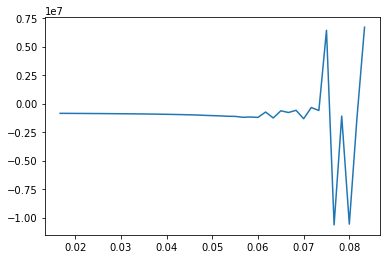

In [11]:
plt.plot(freq_ax[10:51],x_fft[0][10:51])

In [24]:
#number of windows in signal given winLen and winDisp
def NumWins(x, fs, winLen, winDisp):
  return (len(x) - winLen*fs + winDisp*fs) // (winDisp * fs)

#line length
def LL(x):
  return np.sum(np.absolute(np.ediff1d(x)))

#energy
def E(x):
  return np.sum(x**2)

#area
def A(x):
  return np.sum(np.absolute(x))

#spectral amp
def spectral_amplitude(x):
  x_fft = np.fft.fft(x)
  return np.mean(x_fft)

#number of crossings (zero) - not in 
def ZX(x):
  x_demean = x-np.mean(x)
  
  num_crossings = 0

  for i in range(1,len(x)):
    fromAbove = False
    fromBelow = False
    if x_demean[i-1] > 0 and x_demean[i] < 0:
      fromAbove = True
    if x_demean[i-1] < 0 and x_demean[i] > 0:
      fromBelow = True
    
    if fromAbove or fromBelow:
      num_crossings += 1

  return num_crossings

#frequency spectral power 5-15Hz
def SP_5(x):
  X = np.fft.fft(x)
  freq_ax = fs/2 * np.linspace(0,1,len(X.transpose())); # single-sided positive frequency
  freq_to_idx = np.where((freq_ax>=5) & (freq_ax<=15))[0];
  return np.mean(X[freq_to_idx])

#frequency spectral power 20-25Hz
def SP_20(x):
  X = np.fft.fft(x)
  freq_ax = fs/2 * np.linspace(0,1,len(X.transpose())); # single-sided positive frequency
  freq_to_idx = np.where((freq_ax>=20) & (freq_ax<=25))[0];
  return np.mean(X[freq_to_idx])

#frequency spectral power 75-115Hz
def SP_75(x):
  X = np.fft.fft(x)
  freq_ax = fs/2 * np.linspace(0,1,len(X.transpose())); # single-sided positive frequency
  freq_to_idx = np.where((freq_ax>=75) & (freq_ax<=115))[0];
  return np.mean(X[freq_to_idx])

#frequency spectral power 125-160Hz
def SP_125(x):
  X = np.fft.fft(x)
  freq_ax = fs/2 * np.linspace(0,1,len(X.transpose())); # single-sided positive frequency
  freq_to_idx = np.where((freq_ax>=125) & (freq_ax<=160))[0];
  return np.mean(X[freq_to_idx])

#frequency spectral power 160-175Hz
def SP_160(x):
  X = np.fft.fft(x)
  freq_ax = fs/2 * np.linspace(0,1,len(X.transpose())); # single-sided positive frequency
  freq_to_idx = np.where((freq_ax>=160) & (freq_ax<=175))[0];
  return np.mean(X[freq_to_idx])

# Bandpower, can try specifying the following:
# Delta: fmin = 0.5, fmax = 4
# Theta: fmin = 4, fmax = 7
# Alpha: fmin = 8, fmax = 12
# Beta: fmin = 12.5, fmax = 30
# Gamma: fmin = 25, fmax = 140

# From the paper suggestion:
# fmin = 5, fmax = 15
# fmin = 20, fmax = 25
# fmin = 75, fmax = 115
# fmin = 125, fmax = 160
# fmin = 160, fmax = 175

def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

#gets features, load features you want calculated from here
def get_features(filtered_window, fs=1000):
  """
    Write a function that calculates features for a given filtered window. 
    Feel free to use features you have seen before in this class, features that
    have been used in the literature, or design your own!

    Input: 
      filtered_window (window_samples x channels): the window of the filtered ecog signal 
      fs: sampling rate
    Output:
      features (channels x num_features): the features calculated on each channel for the window
  """

  filtered_window_t = filtered_window.transpose()

  features = []

  for ch in filtered_window_t:
    #features.append(np.array([LL(ch), E(ch), SP_5(ch), SP_20(ch), SP_75(ch), SP_125(ch), SP_160(ch)]))
    
#     features.append(np.array([LL(ch), # Line-Length
#                               E(ch), # Energy
#                               bandpower(ch, fs, 0.5, 4), # Delta
#                               bandpower(ch, fs, 4, 7), # Theta
#                               bandpower(ch, fs, 8, 12), # Alpha
#                               bandpower(ch, fs, 12.5, 30), # Beta
#                               bandpower(ch, fs, 25, 140) # Gamma
#                              ])) 

    features.append(np.array([LL(ch), # Line-Length
                              E(ch), # Energy
                              bandpower(ch, fs, 5, 15),
                              bandpower(ch, fs, 20, 25), 
                              bandpower(ch, fs, 75, 115), 
                              bandpower(ch, fs, 125, 160),
                              bandpower(ch, fs, 160, 175) 
                            ])) 
    
    
  features = np.array(features)

  return features

#get_windowed_feats - filters raw ecog signal and finds features
def get_windowed_feats(raw_ecog, fs, window_length, window_overlap):
  """
    Write a function which processes data through the steps of filtering and
    feature calculation and returns features. Points will be awarded for completing
    each step appropriately (note that if one of the functions you call within this script
    returns a bad output, you won't be double penalized). Note that you will need
    to run the filter_data and get_features functions within this function. 

    Inputs:
      raw_eeg (samples x channels): the raw signal
      fs: the sampling rate (1000 for this dataset)
      window_length: the window's length
      window_overlap: the window's overlap
    Output: 
      all_feats (num_windows x (channels x features)): the features for each channel for each time window
        note that this is a 2D array. 
  """

  cleaned_ecog = filter_data(raw_ecog)
  num_wins = NumWins(cleaned_ecog.transpose()[0], fs, window_length, window_overlap)
  all_feats_3d = []
  for winStart in np.arange(0, int(num_wins), 1):
    clip = cleaned_ecog[int(winStart*window_overlap*fs):int(winStart*window_overlap*fs + (window_length *fs))]
    all_feats_3d.append(get_features(clip))

  num_channels = len(all_feats_3d[0])
  num_features = len(all_feats_3d[0][0])

  all_feats = np.zeros([len(all_feats_3d),num_features*num_channels])

  for k in range(int(len(all_feats_3d))):
    q = flatten_list = [j for sub in all_feats_3d[k] for j in sub]
    all_feats[k,:] = q

  return np.array(all_feats)

In [25]:
all_feats = get_windowed_feats(filt_train_ecog_s1, 1000, 0.100, 0.050); #output of get_windowed_feats
feats1_idx = np.arange(0,len(all_feats.transpose()),7)
feats2_idx = np.arange(1,len(all_feats.transpose()),7)
feats3_idx = np.arange(2,len(all_feats.transpose()),7)
feats4_idx = np.arange(3,len(all_feats.transpose()),7)
feats5_idx = np.arange(4,len(all_feats.transpose()),7)
feats6_idx = np.arange(5,len(all_feats.transpose()),7)
feats7_idx = np.arange(6,len(all_feats.transpose()),7)
feat1=[]; feat2=[]; feat3=[]; feat4=[]; feat5=[]; feat6=[]; feat7=[];

for i in feats1_idx:
  feat1.append(all_feats[:][i])
for i in feats2_idx:
  feat2.append(all_feats[:][i])
for i in feats3_idx:
  feat3.append(all_feats[:][i])
for i in feats4_idx:
  feat4.append(all_feats[:][i])
for i in feats5_idx:
  feat5.append(all_feats[:][i])
for i in feats6_idx:
  feat6.append(all_feats[:][i])
for i in feats7_idx:
  feat7.append(all_feats[:][i])

feat1_mean = np.mean(feat1); feat1_std = np.std(feat1);
feat2_mean = np.mean(feat2); feat2_std = np.std(feat2);
feat3_mean = np.mean(feat3); feat3_std = np.std(feat3);
feat4_mean = np.mean(feat4); feat4_std = np.std(feat4);
feat5_mean = np.mean(feat5); feat5_std = np.std(feat5);
feat6_mean = np.mean(feat6); feat6_std = np.std(feat6);
feat7_mean = np.mean(feat7); feat7_std = np.std(feat7);

all_feats_normalized = all_feats
for i in feats1_idx:
  all_feats_normalized[:][i] = np.divide((all_feats[:][i] - feat1_mean),feat1_std)
for i in feats2_idx:
  all_feats_normalized[:][i] = np.divide((all_feats[:][i] - feat2_mean),feat2_std)
for i in feats3_idx:
  all_feats_normalized[:][i] = np.divide((all_feats[:][i] - feat3_mean),feat3_std)
for i in feats4_idx:
  all_feats_normalized[:][i] = np.divide((all_feats[:][i] - feat4_mean),feat4_std)
for i in feats5_idx:
  all_feats_normalized[:][i] = np.divide((all_feats[:][i] - feat5_mean),feat5_std)
for i in feats6_idx:
  all_feats_normalized[:][i] = np.divide((all_feats[:][i] - feat6_mean),feat6_std)
for i in feats7_idx:
  all_feats_normalized[:][i] = np.divide((all_feats[:][i] - feat7_mean),feat7_std)

In [20]:
file = open("all_feats.npy","wb")
np.save(file, all_feats)
file.close()

file = open("all_feats_normalized.npy","wb")
np.save(file, all_feats_normalized)
file.close()